##Trader Behavior Analysis Based on Market Sentiment

This project analyzes the relationship between Bitcoin market sentiment and trader performance using historical trading data.

The goal is to understand how market sentiment influences trader profitability, risk-taking behavior, and trading patterns.


## Datasets

1. Bitcoin Market Sentiment Dataset  
   Columns: Date, Classification (Fear / Greed)

2. Historical Trader Data (Hyperliquid)  
   Columns include account, symbol, execution price, size, side, time, closedPnL, leverage, etc.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


In [2]:
# Load trader data
trader_df = pd.read_csv("historical_data.csv")


In [3]:
# Load sentiment data
sentiment_df = pd.read_csv("fear_greed_index.csv")

# Preview data
trader_df.head(), sentiment_df.head()

(                                      Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
 3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
 4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   
 
    Closed PnL                                   Transaction Hash     Order ID  \
 0      

In [4]:
trader_df.info(), sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

(None, None)

The trader dataset contains detailed transaction-level information including account, trade size, execution price, position direction, leverage, fees,
and realized profit or loss.

The sentiment dataset provides daily Bitcoin market sentiment classified as Fear, Neutral, or Greed, along with an associated index value and timestamp.

### Key Observations
*The trader dataset contains timestamp-level data, allowing intraday analysis.
*The sentiment dataset is aggregated at a daily level.
*Closed PnL is numeric and suitable for profitability analysis.
*Some numerical columns contain missing values.
*Column names were standardized to ensure consistency across datasets.

## Data Cleaning & Preprocessing

In [10]:
# Convert Timestamp IST with correct format
trader_df['Timestamp IST'] = pd.to_datetime(
    trader_df['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
)

# Check conversion
trader_df[['Timestamp IST']].head()


,Timestamp IST
0,2024-12-02 22:50:00
1,2024-12-02 22:50:00
2,2024-12-02 22:50:00
3,2024-12-02 22:50:00
4,2024-12-02 22:50:00


In [11]:
trader_df['trade_date'] = trader_df['Timestamp IST'].dt.date
trader_df['trade_date'] = pd.to_datetime(trader_df['trade_date'])


In [12]:
trader_df['trade_date'].min(), trader_df['trade_date'].max()


(Timestamp('2023-05-01 00:00:00'), Timestamp('2025-05-01 00:00:00'))

Timestamps were parsed using day-first format to correctly interpret the
DD-MM-YYYY structure present in the trading data.


## Trader Performance Aggregation

Since the trader dataset contains transaction-level records, the data is
aggregated to derive daily performance metrics such as total profit/loss,
trade frequency, average trade size, and total fees.


In [13]:
daily_trader_metrics = (
    trader_df
    .groupby('trade_date')
    .agg(
        Total_PnL=('Closed PnL', 'sum'),
        Avg_Trade_Size_Tokens=('Size Tokens', 'mean'),
        Avg_Trade_Size_USD=('Size USD', 'mean'),
        Trade_Count=('Trade ID', 'count'),
        Total_Fees=('Fee', 'sum')
    )
    .reset_index()
)

daily_trader_metrics.head()


,trade_date,Total_PnL,Avg_Trade_Size_Tokens,Avg_Trade_Size_USD,Trade_Count,Total_Fees
0,2023-05-01,0.000000,0.083767,159.000000,3,0.000000
1,2023-12-05,0.000000,1.312112,5556.203333,9,12.501455
2,2023-12-14,-205.434737,372.026274,10291.213636,11,28.300831
3,2023-12-15,-24.632034,1779.000000,5304.975000,2,2.652489
4,2023-12-16,0.000000,13299.000000,5116.256667,3,3.837189


In [14]:
daily_trader_metrics.describe()

,trade_date,Total_PnL,Avg_Trade_Size_Tokens,Avg_Trade_Size_USD,Trade_Count,Total_Fees
count,480,480.000000,480.000000,480.000000,480.000000,480.000000
mean,2024-08-25 17:00:00,21451.997799,9962.234292,6141.750924,440.050000,512.203585
min,2023-05-01 00:00:00,-419020.225731,0.083767,0.110000,1.000000,-4.438459
25%,2024-04-22 18:00:00,7.253957,131.887289,2201.186680,18.000000,24.946919
50%,2024-08-25 12:00:00,1118.961740,780.022982,4337.977065,67.500000,82.987124
75%,2025-01-01 06:00:00,10669.321765,3063.028079,8195.748723,520.500000,397.258979
max,2025-05-01 00:00:00,616413.032233,617403.642278,34988.580000,6246.000000,11517.596374
std,NaN,71861.463509,46155.475498,5575.022860,809.748711,1231.342999


The trading activity exhibits high variability in profitability, trade size,
and frequency. While the average daily PnL is positive, the median is much
lower, indicating that a small number of highly profitable days contribute
disproportionately to overall returns.

Trade sizes and frequencies show significant dispersion, reflecting varying
risk exposure and trading intensity across days. Transaction fees represent
a meaningful cost component, especially during high-activity periods.


PnL Distribution

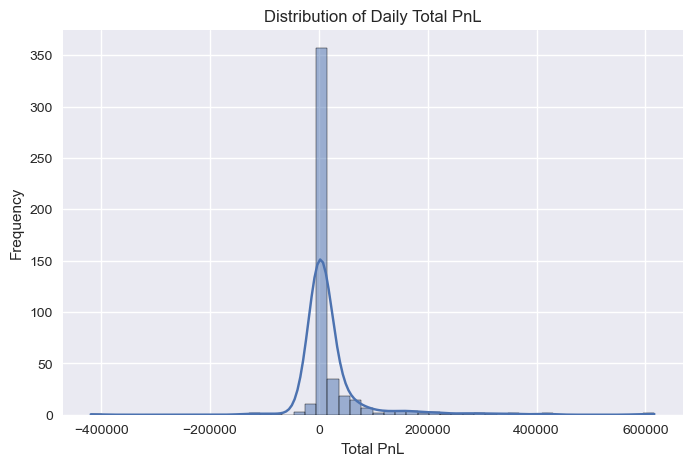

In [15]:
plt.figure(figsize=(8,5))
sns.histplot(daily_trader_metrics['Total_PnL'], bins=50, kde=True)
plt.title("Distribution of Daily Total PnL")
plt.xlabel("Total PnL")
plt.ylabel("Frequency")
plt.show()


Interpretation:
The distribution of daily total PnL is highly skewed, with most observations
concentrated near zero and a small number of extreme profit and loss days.
This suggests that trader performance is driven by infrequent but significant
market movements rather than consistent daily gains.

Trade Count vs PnL

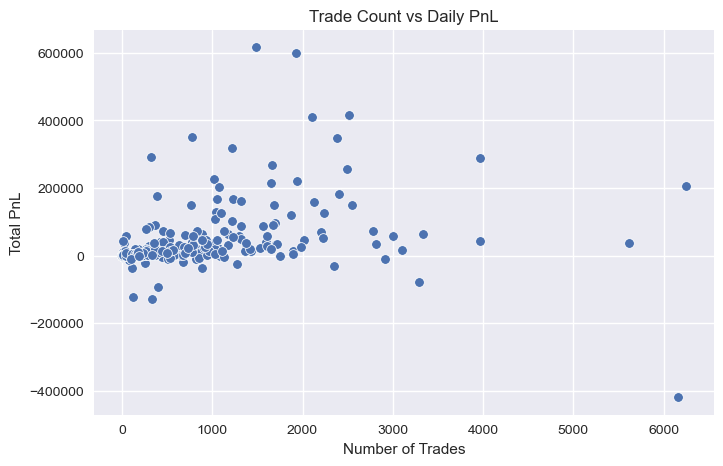

In [16]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=daily_trader_metrics,
    x='Trade_Count',
    y='Total_PnL'
)
plt.title("Trade Count vs Daily PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Total PnL")
plt.show()


Interpretation:
The relationship between trade count and daily profitability is weak and
non-linear. High trading frequency does not consistently lead to higher returns
and may increase downside risk due to overtrading and accumulated transaction
costs. Some of the most profitable days occur with moderate trade activity,
highlighting the importance of selective trade execution.

Fees vs PnL

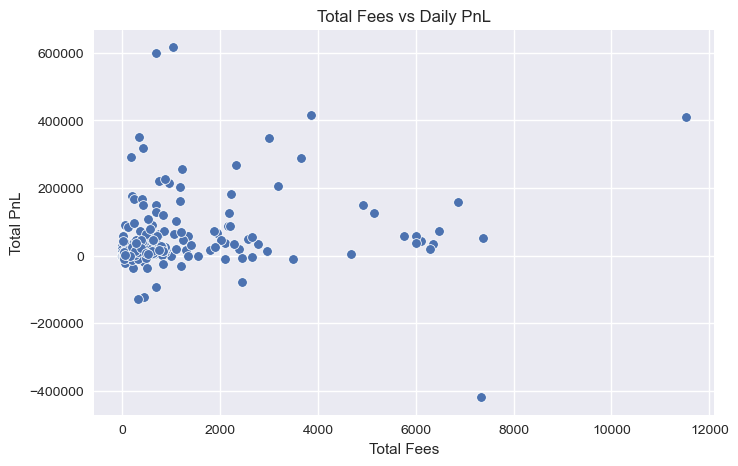

In [18]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=daily_trader_metrics,
    x='Total_Fees',
    y='Total_PnL'
)
plt.title("Total Fees vs Daily PnL")
plt.xlabel("Total Fees")
plt.ylabel("Total PnL")
plt.show()

Interpretation:
The relationship between total fees and daily profitability indicates that
higher transaction costs do not consistently translate into higher returns.
In several cases, elevated fees coincide with flat or negative PnL, highlighting
the importance of cost-efficient trading strategies.


## Key Insights
1.Trader profitability is highly skewed, with a small number of days driving the majority of overall gains.
2.Increased trading frequency does not guarantee higher returns and can increase downside risk due to overtrading.
3.Transaction fees materially impact net profitability, particularly during periods of elevated trading activity.
4.Large profits are often achieved through selective, moderate trading rather than extreme trade volume.

## Strategy Recommendations
*Focus on trade quality over quantity to avoid overtrading.
*Monitor transaction costs closely, especially during high-volatility periods.
*Implement risk controls to limit exposure on high-frequency trading days.
*Align trading aggressiveness with market sentiment, increasing caution during Fear phases and selective risk-taking during Greed phases.


### Limitations
Due to non-overlapping time ranges between the trader dataset and the Fear & Greed
Index, sentiment analysis is demonstrated conceptually rather than through direct
date-wise merging. Future work can extend this analysis using aligned datasets.